# Lab 3: Cooling models of the oceanic lithosphere

In this lab, we will calculate the bathymetry of the oceans predicted by two conductive cooling models of the oceanic lithosphere: the half-space model and the plate model. To assess model predictions, we'll use bathymetry data from [ETOPO1](https://doi.org/10.7289/V5C8276M) and age of the oceanic lithosphere data from [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743).

Learning objectives:

* Expand on the theorical knowledge acquired in [Lecture 3](https://www.leouieda.com/envs398/slides/3-oceanic-lithosphere/).
* Apply the principles of isostatic equilibrium to estimate bathymetry from cooling models.
* Convert the theoretical knowledge into computations that can be used to model real data.

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As before, the first thing to do is load the Python libraries that we'll be using. We'll group all our imports here at the top to make it easier to see what we're using.

In [1]:
# The base of the entire scientific Python stack
import numpy as np
# Scipy defines a bunch of scientific goodness on top of numpy
import scipy.integrate
import scipy.special
# For making plots and figures
import matplotlib.pyplot as plt
# To load and operate on data tables
import pandas as pd

## Load the data

The data that we will try to fit with our cooling models are in a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file in the `data` folder. We'll use `pandas` to load it below. The data are bathymetry and age measurements for the South Pacific.

In [2]:
pacific = pd.read_csv("data/pacific-bathymetry-age.csv")
pacific

,longitude,latitude,age_myr,bathymetry_m
0,-169.255319,-69.257143,72.93,-4070.0
1,-167.765957,-69.257143,27.60,-4054.0
2,-166.276596,-69.257143,30.17,-4077.0
3,-164.787234,-69.257143,34.32,-3933.0
4,-163.297872,-69.257143,43.29,-3846.0
...,...,...,...,...
1640,-106.702128,-18.742857,7.44,-3949.0
1641,-105.212766,-18.742857,8.88,-4032.0
1642,-103.723404,-18.742857,10.39,-4051.0
1643,-102.234043,-18.742857,11.97,-4096.0


The dataset contains the coordinates of the data points and their associated age (in million years) and bathymetry (in meters). Below, we'll plot the age and bathymetry data using a scatter plot.

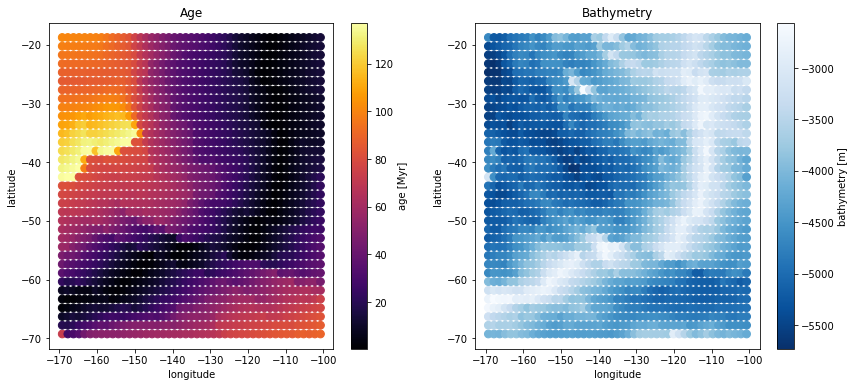

In [3]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("Age")
plt.scatter(pacific.longitude, pacific.latitude, c=pacific.age_myr, s=60, cmap="inferno")
plt.colorbar(label='age [Myr]')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.subplot(1, 2, 2)
plt.title("Bathymetry")
plt.scatter(pacific.longitude, pacific.latitude, c=pacific.bathymetry_m, s=60, cmap="Blues_r")
plt.colorbar(label='bathymetry [m]')
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In the grids, we can see a ridge with associated transform faults. There is also a very old section of lithosphere (> 120 Myr) in the deepest part of the grid that is not associated with the current spreading center.

----

### YOUR TURN

Make a plot of the age (x-axis) versus bathymetry (y-axis) below. 

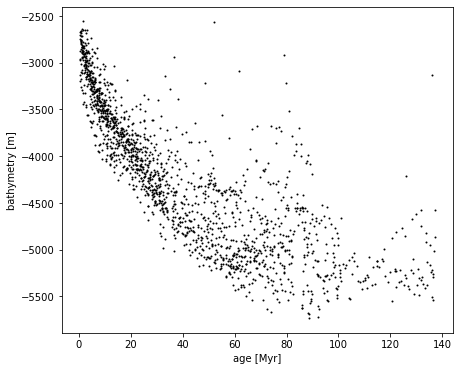

In [4]:
plt.figure(figsize=(7, 6))

# Fill in the lines below with your own code
plt.plot(pacific.age_myr, pacific.bathymetry_m, ".k", markersize=2)

plt.xlabel("age [Myr]")
plt.ylabel("bathymetry [m]")
plt.savefig("figures/cooling-model-bathymetry-halfspace.png")
plt.show()

You plot should look something like this:

![]()

### Questions

* What do the outliers in this graph (the shallow points in old lithosphere) most likely represent?


----

## Predicting bathymetry from half-space cooling



The main idea for estimating bathymetry from cooling is models is that we assume that the oceanic lithosphere is in isostatic equilibrium. As we say in Lecture 2, this means that at a given compensation depth $D$, the pressure from the rock overburden is constant. This translated into vertical columns of material needing to have the same total mass.

![](https://raw.githubusercontent.com/leouieda/envs398/master/slides/3-oceanic-lithosphere/cooliing-and-bathymetry.svg)

For a given column at $x = x_1$ (or $t = t_1$), the total mass of the column must be the same as the total mass at the ridge. Since the ridge has no lithosphere yet, the total mass at the ridge




$$ w(t) = w_r + \dfrac{2 \rho_a \alpha_V (T_a - T_0)}{\rho_a - \rho_w} \sqrt{\dfrac{\alpha t}{\pi}} $$



We can make a *Python function* that calculates the equation above. The physical parameters that our function will take as input are:

* $w_r$ = bathymetry at the ridge = `ridge_depth` in km
* $\rho_w$ and $\rho_a$ = density of water and the asthenosphere (mantle) = `density_water` and `density_mantle` in kg/m³
* $\alpha_V$ = coefficient of thermal expansion = `thermal_expansion` in 1/K
* $\alpha$ = thermal diffusivity = `diffusivity` in mm²/s
* $T_a$ and $T_0$ = temperature of the asthemosphere and surface = `temperature_mantle` and `temperature_surface` in K

Finally, the function will also receive the age of the lithosphere $t$ in million years.

Below you'll find the code for this function. Notice that we need to take special care with the units.

In [5]:
def bathymetry_halfspace(age, ridge_depth, density_mantle, density_water, temperature_mantle, temperature_surface, thermal_expansion, diffusivity):
    "Predict bathymetry from the half-space cooling model"
    bathymetry = (
        # Convert from km to m
        ridge_depth * 1e3
        + 2 * density_mantle * thermal_expansion * (temperature_mantle - temperature_surface) / (
            density_mantle - density_water
            # Convert diffusivity from mm²/s to m²/s
            # Convert the age from Myr to s
        ) * np.sqrt(diffusivity * 1e-6 *  age * 31557600000000 / np.pi)
    )
    # -1 because the equation gives us thickness of the water layer
    return -1 * bathymetry    

----

### YOUR TURN

Complete the code below to use our new function to predict the half-space model bathymetry for the given age range.

The input parameters should be:

* $w_r = 2.5\ km$
* $\rho_w = 1000\ kg/m^3$ and $\rho_a = 3300\ kg/m^3$
* $\alpha_V = 3 \times 10^{-5}\ 1/K$
* $\alpha = 1\ mm^2/s$
* $T_a = 1600\ K$ and $T_0 = 273\ K$

In [6]:
ages = np.linspace(0, 140, 100)
# Fill in the lines below with your own code
predicted_bathymetry_hspace = bathymetry_halfspace(
    ages,
    ridge_depth=2.5,
    density_mantle=3300,
    density_water=1000,
    temperature_mantle=1600,
    temperature_surface=273,
    thermal_expansion=3e-5,
    diffusivity=1,
)

Now add a **red line** to the plot below with the half-space model predictions (`predicted_bathymetry_hspace`).

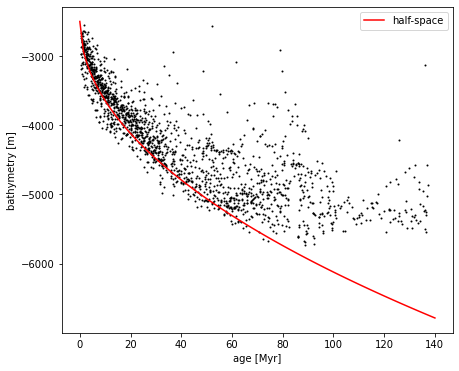

In [7]:
plt.figure(figsize=(7, 6))
plt.plot(pacific.age_myr, pacific.bathymetry_m, ".k", markersize=2)

# Fill in the lines below with your own code
plt.plot(ages, predicted_bathymetry_hspace, "-r", label="half-space")
plt.legend()

plt.xlabel("age [Myr]")
plt.ylabel("bathymetry [m]")
plt.savefig("figures/cooling-model-bathymetry-halfspace.png")
plt.show()

You plot should look something like this:

![]()

### Questions

* How well does the model fit the data?
* Is this consistent with what we saw for the heat flow data?

**Place your answers here** (double click on the text to edit it).

----

## Predicting bathymetry from the plate model


$$
w(t) = w_r + \dfrac{\rho_m \alpha_V (T_a - T_0) L}{\rho_a - \rho_w} \left[ \dfrac{1}{2} - \dfrac{4}{\pi^2}
\sum\limits_{m=0}^{\infty} \dfrac{1}{(1 + 2m)^2} \exp\left(-\dfrac{t \alpha \pi^2 (1 + 2m)^2}{L^2}\right) \right]
$$

The function that implemets the bathymetry calculation for the plate model will be very similar to the one for the half-space model. The inputs will be same except for the added `thickness` argument represeting the plate thickness $L$.

----

### YOUR TURN

Complete the function below to calculate the equation shown above. The only part left to add is the summation term. Summation in programming is usually calculated using [the accumulator pattern](http://swcarpentry.github.io/python-novice-gapminder/12-for-loops/index.html).

Be aware of the units! We want the output to be in meters. Remember that the arguments of exponentials have to be dimensionless. So you'll have to make sure the units of the diffusivity, age, and thickness match.

In [8]:
def bathymetry_plate(
    age, thickness, ridge_depth, density_mantle, density_water, temperature_mantle, temperature_surface, thermal_expansion, diffusivity
):
    "Predicted bathymetry for the plate cooling model"
    multiplier = density_mantle * thermal_expansion * (temperature_mantle - temperature_surface) * thickness * 1e3 / (
        density_mantle - density_water
    )
    # Calculate the summation term. We'll truncate the sum at m=99
    sum_total = 0
    for m in range(0, 100):
        sum_total = sum_total  + (
            # Fill in the lines below with your own code
            1 / (1 + 2 * m)**2 * np.exp(
                - diffusivity * 1e-12 * (1 + 2 * m)**2 * np.pi**2 * age * 31557600000000 / thickness**2
            )
        )
    # The 1e3 converts from km to m
    bathymetry = ridge_depth * 1e3 + multiplier * 1 / 2 - multiplier * (4 / np.pi**2) * sum_total
    return -1 * bathymetry

To test your code, run the lines below to calculate the bathymetry predictions for the plate model using the same parameters used for the half-space model.

The **thickness of the plate should be 150 km** here.

In [9]:
thickness = 150
# Fill in the lines below with your own code
predicted_bathymetry_plate = bathymetry_plate(
    ages,
    thickness=150,
    ridge_depth=2.5,
    density_mantle=3300,
    density_water=1000,
    temperature_mantle=1600,
    temperature_surface=273,
    thermal_expansion=3e-5,
    diffusivity=1,
)

Add the predictions from the plate model to the data plot.

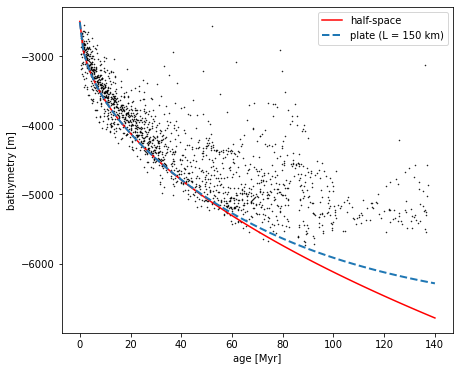

In [10]:
plt.figure(figsize=(7, 6))
plt.plot(pacific.age_myr, pacific.bathymetry_m, ".k", markersize=1)

# Fill in the lines below with your own code
plt.plot(ages, predicted_bathymetry_hspace, "-r", label="half-space")
plt.plot(ages, predicted_bathymetry_plate, "--", label="plate (L = {} km)".format(thickness), linewidth=2)
plt.legend()

plt.xlabel("age [Myr]")
plt.ylabel("bathymetry [m]")
plt.savefig("figures/cooling-model-bathymetry-plate.png", dpi=200)
plt.show()

You plot should look something like this:

![]()

Now we need to determine **which plate thickness $L$ best fits the data**. To do this, repeat the calculation above varying the value of `thickness`.

**BONUTS**: To really take advantage of the power of programming, I would suggest using a `for` loop to make a single plot with the model predictions for various values of $L$. This is much better than changing $L$ manually and re-running the code every time. 

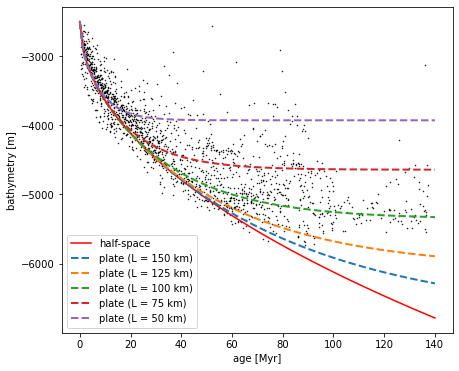

In [11]:
# Fill in the lines below with your own code
plt.figure(figsize=(7, 6))
plt.plot(pacific.age_myr, pacific.bathymetry_m, ".k", markersize=1)
plt.plot(ages, predicted_bathymetry_hspace, "-r", label="half-space")
for thickness in [150, 125, 100, 75, 50]:
    predicted_bathymetry_plate = bathymetry_plate(
        ages,
        thickness=thickness,
        ridge_depth=2.5,
        density_mantle=3300,
        density_water=1000,
        temperature_mantle=1600,
        temperature_surface=273,
        thermal_expansion=3e-5,
        diffusivity=1,
    )
    plt.plot(ages, predicted_bathymetry_plate, "--", label="plate (L = {} km)".format(thickness), linewidth=2)
plt.legend()
plt.xlabel("age [Myr]")
plt.ylabel("bathymetry [m]")
plt.savefig("figures/cooling-model-bathymetry-plate-range.png", dpi=200)
plt.show()

### Questions

* Which plate thickness best fits the data?
* Bathymetry is realatively well known but heat flow in the oceans is difficult to measure. How could these models help our understanding of the Earth's energy balance?